🚀 Starting Complete Job Market Analysis
Fetching HTML content from Google Drive...
✓ Successfully fetched HTML content
Parsing job listings...
✓ Found 16 job cards using selector: .job_seen_beacon
✓ Successfully parsed 16 job listings
Cleaning and structuring data...
✓ Cleaned data: 16 job listings
✓ Extracted 17 skill mentions

JOB MARKET ANALYSIS REPORT

📊 OVERVIEW:
Total Job Listings: 16
Unique Companies: 15
Unique Locations: 0
Total Skills Identified: 17

🏢 TOP HIRING COMPANIES:
 1. Aon: 2 jobs
 2. Rockefeller Capital Management: 1 jobs
 3. Assured Guaranty: 1 jobs
 4. University of North Texas: 1 jobs
 5. County of DuPage: 1 jobs
 6. Delta Dental of Wisconsin Inc: 1 jobs
 7. BlackRock Investments: 1 jobs
 8. First Horizon: 1 jobs
 9. Cerris: 1 jobs
10. Rondout Valley Central School District: 1 jobs

📍 TOP JOB LOCATIONS:

🔥 MOST IN-DEMAND SKILLS:
 1. R: 16 mentions
 2. Api: 1 mentions

🌆 SKILLS BY TOP CITIES:

Creating visualizations...


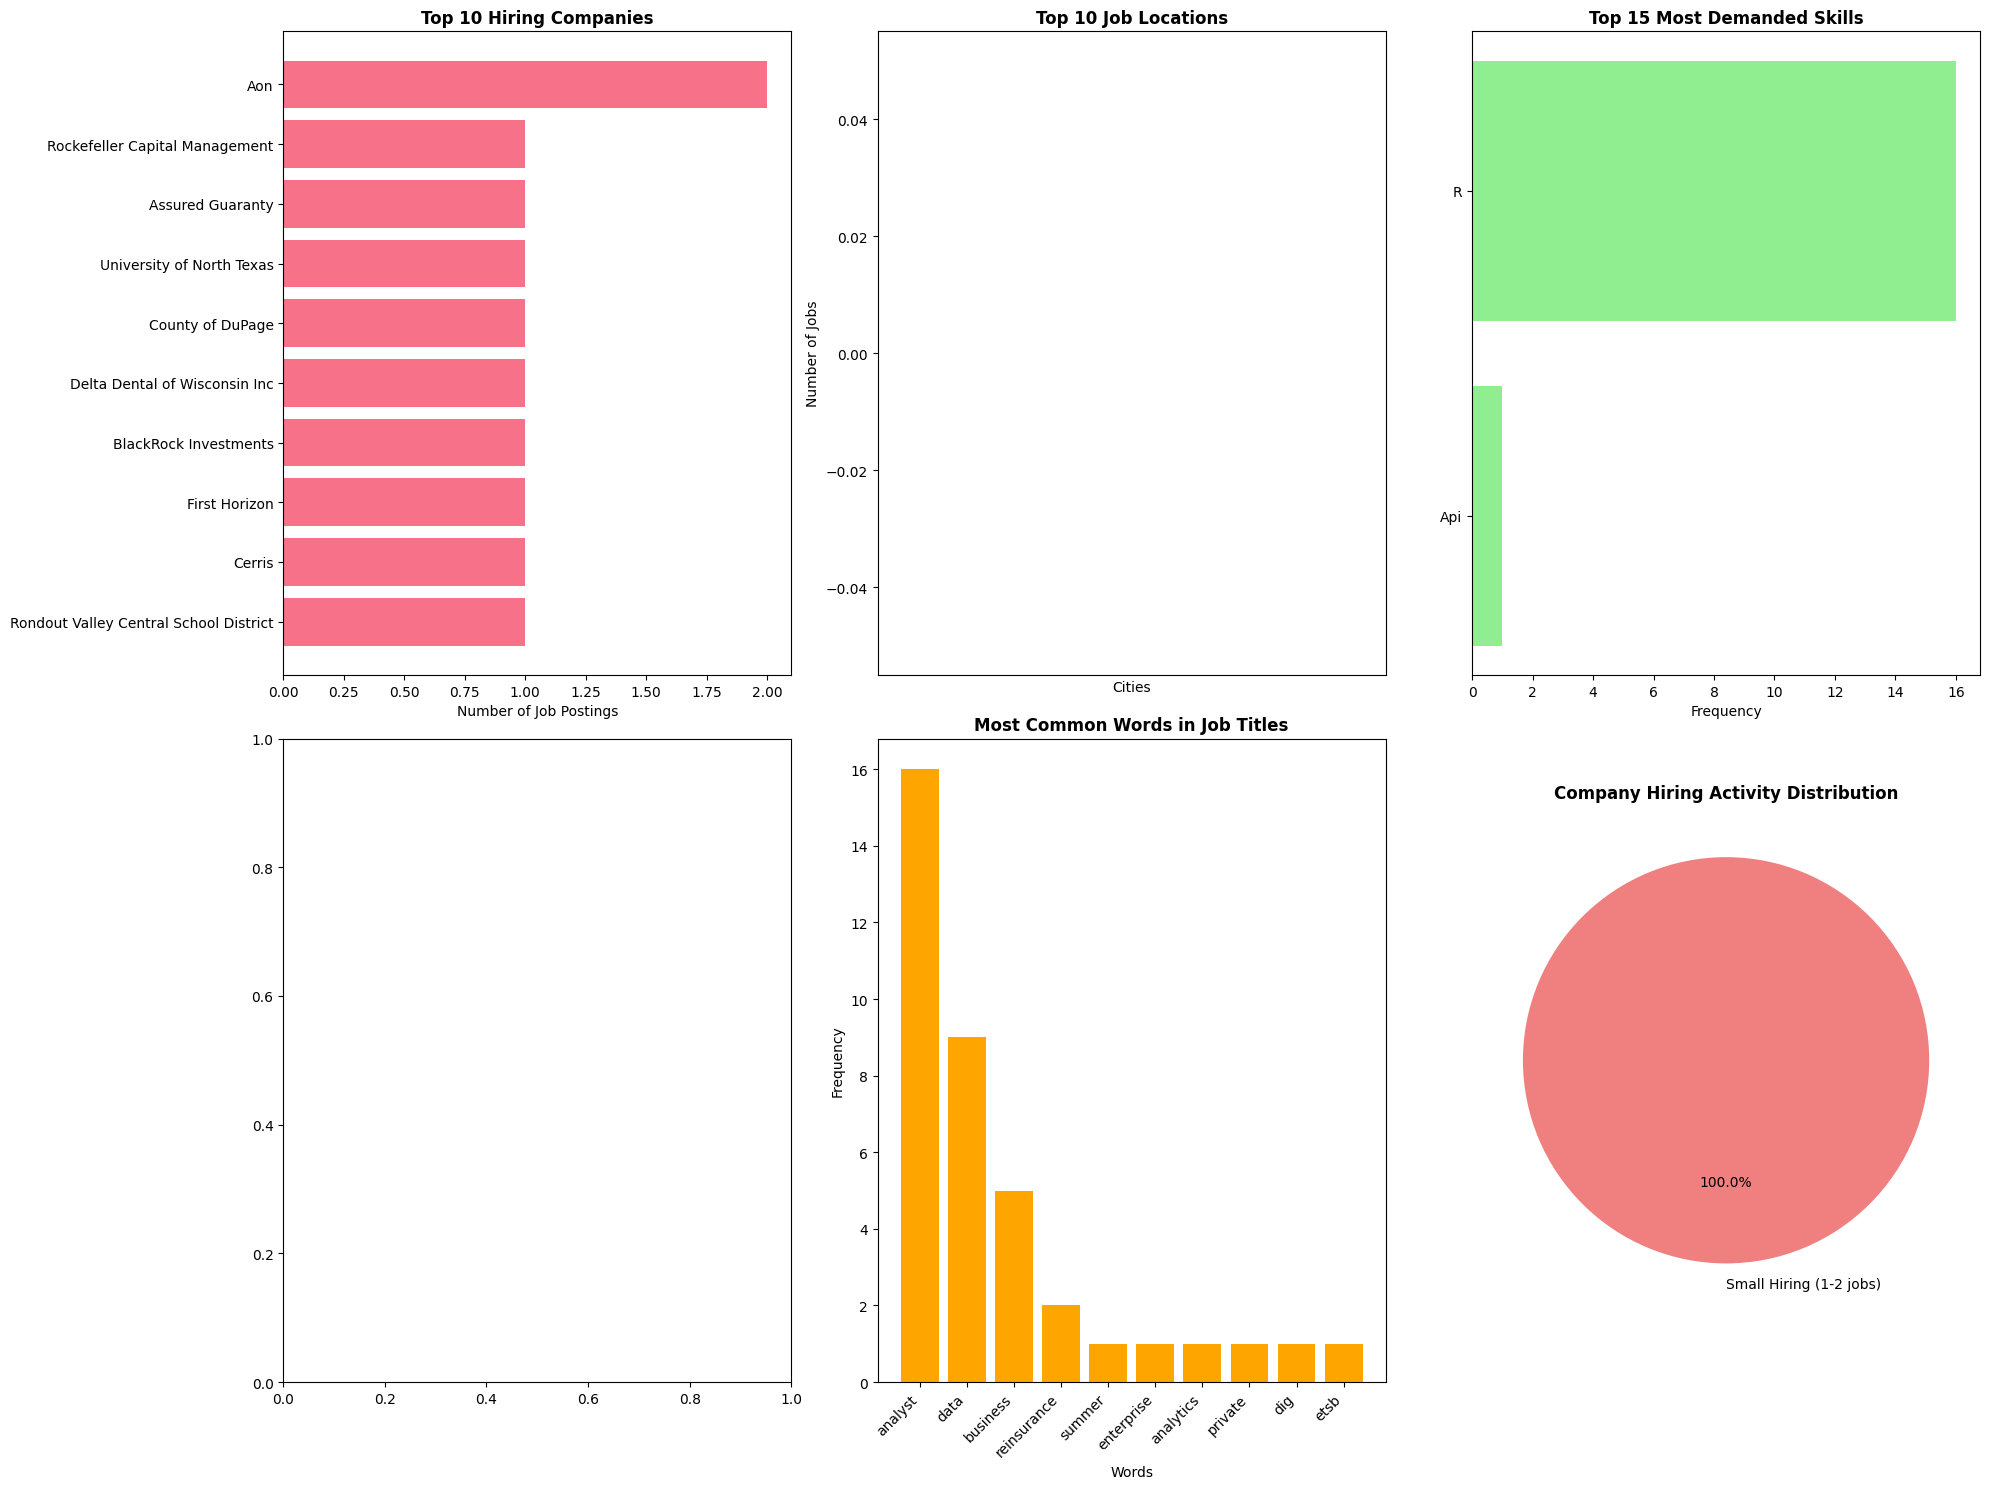

✓ Visualizations created successfully!

Exporting data to job_analysis_results...
✓ Job listings exported to job_analysis_results_jobs.csv
✓ Skills data exported to job_analysis_results_skills.csv
✓ Summary report exported to job_analysis_results_summary.txt

🎉 Analysis Complete!
Check the generated CSV files and summary report for detailed results.


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class JobScraperAnalyzer:
    def __init__(self):
        self.raw_data = []
        self.cleaned_data = None
        self.skills_keywords = [
            # Programming Languages
            'python', 'java', 'javascript', 'c++', 'c#', 'php', 'ruby', 'go', 'swift', 'kotlin',
            'typescript', 'scala', 'r', 'matlab', 'sql', 'html', 'css', 'react', 'angular', 'vue',

            # Frameworks & Technologies
            'django', 'flask', 'spring', 'node.js', 'express', 'laravel', 'rails', 'asp.net',
            'tensorflow', 'pytorch', 'keras', 'scikit-learn', 'pandas', 'numpy',

            # Databases
            'mysql', 'postgresql', 'mongodb', 'redis', 'oracle', 'sqlite', 'elasticsearch',

            # Cloud & DevOps
            'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'jenkins', 'gitlab', 'github',
            'terraform', 'ansible', 'linux', 'ubuntu',

            # Skills & Concepts
            'machine learning', 'artificial intelligence', 'data science', 'data analysis',
            'web development', 'mobile development', 'ui/ux', 'project management',
            'agile', 'scrum', 'api', 'rest', 'microservices', 'blockchain', 'cybersecurity',

            # Office & Business
            'excel', 'powerpoint', 'word', 'communication', 'teamwork', 'leadership'
        ]

    def fetch_html_content(self, url):
        """Fetch HTML content from the provided URL"""
        try:
            print("Fetching HTML content from Google Drive...")
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            print("✓ Successfully fetched HTML content")
            return response.text
        except requests.RequestException as e:
            print(f"Error fetching content: {e}")
            return None

    def parse_job_listings(self, html_content):
        """Parse job listings from HTML content"""
        print("Parsing job listings...")
        soup = BeautifulSoup(html_content, 'html.parser')

        # Common selectors for Indeed job listings
        job_selectors = [
            'div[data-jk]',  # Indeed job cards
            '.job_seen_beacon',  # Another Indeed selector
            '.jobsearch-SerpJobCard',  # Classic Indeed selector
            '.slider_container .slider_item',  # Slider items
            'article',  # Generic article tags
            '.job-listing',  # Generic job listing class
        ]

        jobs_found = False

        for selector in job_selectors:
            job_cards = soup.select(selector)
            if job_cards:
                print(f"✓ Found {len(job_cards)} job cards using selector: {selector}")
                jobs_found = True
                break

        if not jobs_found:
            # Fallback: look for any divs that might contain job information
            print("Trying fallback approach...")
            job_cards = soup.find_all(['div', 'article'], class_=lambda x: x and any(
                keyword in str(x).lower() for keyword in ['job', 'position', 'role', 'vacancy']
            ))
            print(f"Found {len(job_cards)} potential job containers with fallback")

        jobs = []

        for i, card in enumerate(job_cards[:50]):  # Limit to first 50 for processing
            job_data = self._extract_job_data(card, i)
            if job_data and job_data['title']:  # Only add if we found a title
                jobs.append(job_data)

        self.raw_data = jobs
        print(f"✓ Successfully parsed {len(jobs)} job listings")
        return jobs

    def _extract_job_data(self, card, index):
        """Extract job data from a single job card"""
        job = {
            'title': '',
            'company': '',
            'location': '',
            'description': '',
            'skills': [],
            'posted_date': '',
            'salary': ''
        }

        # Try multiple selectors for each field
        title_selectors = [
            'h2 a', 'h3 a', '.jobTitle a', '[data-testid="job-title"]',
            'a[data-jk]', '.jobTitle', 'h2', 'h3', 'h4', '.job-title'
        ]

        company_selectors = [
            '.companyName', '[data-testid="company-name"]', '.company',
            'span[title]', '.jobCompany', '.employer'
        ]

        location_selectors = [
            '[data-testid="job-location"]', '.companyLocation', '.location',
            '.jobLocation', '.job-location'
        ]

        # Extract title
        job['title'] = self._extract_text_by_selectors(card, title_selectors)

        # Extract company
        job['company'] = self._extract_text_by_selectors(card, company_selectors)

        # Extract location
        job['location'] = self._extract_text_by_selectors(card, location_selectors)

        # Extract description/summary
        desc_selectors = ['.summary', '.job-summary', '[data-testid="job-snippet"]']
        job['description'] = self._extract_text_by_selectors(card, desc_selectors)

        # If no description found, get all text from the card
        if not job['description']:
            job['description'] = card.get_text(' ', strip=True)

        # Extract skills from description
        job['skills'] = self._extract_skills_from_text(job['description'] + ' ' + job['title'])

        # Try to extract salary
        salary_patterns = [
            r'Rs\.?\s*(\d{1,3}(?:,\d{3})*(?:\.\d{2})?)\s*-?\s*(?:to\s*)?(?:Rs\.?\s*)?(\d{1,3}(?:,\d{3})*(?:\.\d{2})?)?',
            r'PKR\s*(\d{1,3}(?:,\d{3})*)',
            r'(\d{1,3}(?:,\d{3})*)\s*PKR'
        ]

        full_text = card.get_text()
        for pattern in salary_patterns:
            match = re.search(pattern, full_text, re.IGNORECASE)
            if match:
                job['salary'] = match.group(0)
                break

        return job

    def _extract_text_by_selectors(self, element, selectors):
        """Try multiple CSS selectors to extract text"""
        for selector in selectors:
            try:
                found = element.select_one(selector)
                if found and found.get_text(strip=True):
                    return found.get_text(strip=True)
            except:
                continue
        return ''

    def _extract_skills_from_text(self, text):
        """Extract skills from job description text"""
        if not text:
            return []

        text_lower = text.lower()
        found_skills = []

        for skill in self.skills_keywords:
            if skill.lower() in text_lower:
                found_skills.append(skill.title())

        return list(set(found_skills))  # Remove duplicates

    def clean_data(self):
        """Clean and structure the scraped data"""
        print("Cleaning and structuring data...")

        if not self.raw_data:
            print("No data to clean!")
            return None

        # Convert to DataFrame
        df = pd.DataFrame(self.raw_data)

        # Clean text fields
        text_columns = ['title', 'company', 'location', 'description']
        for col in text_columns:
            if col in df.columns:
                df[col] = df[col].astype(str).str.strip()
                df[col] = df[col].replace('', pd.NA)

        # Remove rows where title is missing or empty
        df = df.dropna(subset=['title'])
        df = df[df['title'] != '']

        # Clean location data - extract city
        if 'location' in df.columns:
            df['city'] = df['location'].str.split(',').str[0].str.strip()
            df['city'] = df['city'].replace('', 'Unknown')

        # Expand skills column for analysis
        skills_expanded = []
        for idx, row in df.iterrows():
            skills = row.get('skills', [])
            if isinstance(skills, list) and skills:
                for skill in skills:
                    skills_expanded.append({
                        'job_index': idx,
                        'title': row['title'],
                        'company': row['company'],
                        'city': row.get('city', 'Unknown'),
                        'skill': skill
                    })

        self.skills_df = pd.DataFrame(skills_expanded)
        self.cleaned_data = df

        print(f"✓ Cleaned data: {len(df)} job listings")
        print(f"✓ Extracted {len(skills_expanded)} skill mentions")

        return df

    def analyze_data(self):
        """Perform comprehensive data analysis"""
        if self.cleaned_data is None:
            print("No cleaned data available for analysis!")
            return

        print("\n" + "="*50)
        print("JOB MARKET ANALYSIS REPORT")
        print("="*50)

        df = self.cleaned_data

        # Basic statistics
        print(f"\n📊 OVERVIEW:")
        print(f"Total Job Listings: {len(df)}")
        print(f"Unique Companies: {df['company'].nunique()}")
        print(f"Unique Locations: {df['city'].nunique()}")
        print(f"Total Skills Identified: {len(self.skills_df)}")

        # Top companies
        print(f"\n🏢 TOP HIRING COMPANIES:")
        top_companies = df['company'].value_counts().head(10)
        for i, (company, count) in enumerate(top_companies.items(), 1):
            print(f"{i:2d}. {company}: {count} jobs")

        # Top locations
        print(f"\n📍 TOP JOB LOCATIONS:")
        top_cities = df['city'].value_counts().head(10)
        for i, (city, count) in enumerate(top_cities.items(), 1):
            print(f"{i:2d}. {city}: {count} jobs")

        # Most in-demand skills
        if not self.skills_df.empty:
            print(f"\n🔥 MOST IN-DEMAND SKILLS:")
            top_skills = self.skills_df['skill'].value_counts().head(15)
            for i, (skill, count) in enumerate(top_skills.items(), 1):
                print(f"{i:2d}. {skill}: {count} mentions")

        # Skills by city analysis
        if not self.skills_df.empty:
            print(f"\n🌆 SKILLS BY TOP CITIES:")
            top_3_cities = df['city'].value_counts().head(3).index

            for city in top_3_cities:
                city_skills = self.skills_df[self.skills_df['city'] == city]['skill'].value_counts().head(5)
                if not city_skills.empty:
                    print(f"\n   {city}:")
                    for skill, count in city_skills.items():
                        print(f"     • {skill}: {count}")

    def create_visualizations(self):
        """Create comprehensive visualizations"""
        if self.cleaned_data is None or self.cleaned_data.empty:
            print("No data available for visualization!")
            return

        print("\nCreating visualizations...")

        # Set up the plotting style
        plt.style.use('default')
        sns.set_palette("husl")

        # Create subplots
        fig = plt.figure(figsize=(20, 15))

        # 1. Top Companies
        plt.subplot(2, 3, 1)
        top_companies = self.cleaned_data['company'].value_counts().head(10)
        plt.barh(range(len(top_companies)), top_companies.values)
        plt.yticks(range(len(top_companies)), top_companies.index)
        plt.xlabel('Number of Job Postings')
        plt.title('Top 10 Hiring Companies', fontsize=12, fontweight='bold')
        plt.gca().invert_yaxis()

        # 2. Top Locations
        plt.subplot(2, 3, 2)
        top_cities = self.cleaned_data['city'].value_counts().head(10)
        plt.bar(range(len(top_cities)), top_cities.values, color='skyblue')
        plt.xticks(range(len(top_cities)), top_cities.index, rotation=45, ha='right')
        plt.xlabel('Cities')
        plt.ylabel('Number of Jobs')
        plt.title('Top 10 Job Locations', fontsize=12, fontweight='bold')

        # 3. Most Demanded Skills
        if not self.skills_df.empty:
            plt.subplot(2, 3, 3)
            top_skills = self.skills_df['skill'].value_counts().head(15)
            plt.barh(range(len(top_skills)), top_skills.values, color='lightgreen')
            plt.yticks(range(len(top_skills)), top_skills.index)
            plt.xlabel('Frequency')
            plt.title('Top 15 Most Demanded Skills', fontsize=12, fontweight='bold')
            plt.gca().invert_yaxis()

        # 4. Skills Distribution by Top Cities
        if not self.skills_df.empty:
            plt.subplot(2, 3, 4)
            top_3_cities = self.cleaned_data['city'].value_counts().head(3).index
            city_skills_data = []

            for city in top_3_cities:
                city_skills = self.skills_df[self.skills_df['city'] == city]['skill'].value_counts().head(5)
                for skill, count in city_skills.items():
                    city_skills_data.append({'City': city, 'Skill': skill, 'Count': count})

            if city_skills_data:
                city_skills_df = pd.DataFrame(city_skills_data)
                pivot_data = city_skills_df.pivot(index='Skill', columns='City', values='Count').fillna(0)

                sns.heatmap(pivot_data, annot=True, fmt='g', cmap='YlOrRd', cbar=True)
                plt.title('Top Skills by City (Heatmap)', fontsize=12, fontweight='bold')
                plt.xlabel('Cities')
                plt.ylabel('Skills')

        # 5. Job Titles Word Cloud Data (Top Job Title Words)
        plt.subplot(2, 3, 5)
        all_titles = ' '.join(self.cleaned_data['title'].astype(str))
        # Simple word frequency for job titles
        words = re.findall(r'\b[a-zA-Z]{3,}\b', all_titles.lower())
        stop_words = {'and', 'the', 'for', 'with', 'jobs', 'job', 'position', 'role'}
        words = [word for word in words if word not in stop_words]
        word_freq = Counter(words).most_common(10)

        if word_freq:
            words, frequencies = zip(*word_freq)
            plt.bar(words, frequencies, color='orange')
            plt.xticks(rotation=45, ha='right')
            plt.xlabel('Words')
            plt.ylabel('Frequency')
            plt.title('Most Common Words in Job Titles', fontsize=12, fontweight='bold')

        # 6. Company Size Distribution (based on job postings)
        plt.subplot(2, 3, 6)
        company_job_counts = self.cleaned_data['company'].value_counts()

        # Categorize companies by hiring activity
        categories = []
        for count in company_job_counts:
            if count >= 5:
                categories.append('Large Hiring (5+ jobs)')
            elif count >= 3:
                categories.append('Medium Hiring (3-4 jobs)')
            else:
                categories.append('Small Hiring (1-2 jobs)')

        category_counts = Counter(categories)
        plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%',
                startangle=90, colors=['lightcoral', 'lightskyblue', 'lightgreen'])
        plt.title('Company Hiring Activity Distribution', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

        print("✓ Visualizations created successfully!")

    def export_data(self, filename='job_analysis_results'):
        """Export cleaned data and analysis results"""
        if self.cleaned_data is None:
            print("No data to export!")
            return

        print(f"\nExporting data to {filename}...")

        # Export main job data
        self.cleaned_data.to_csv(f'{filename}_jobs.csv', index=False)
        print(f"✓ Job listings exported to {filename}_jobs.csv")

        # Export skills data
        if not self.skills_df.empty:
            self.skills_df.to_csv(f'{filename}_skills.csv', index=False)
            print(f"✓ Skills data exported to {filename}_skills.csv")

        # Create summary report
        with open(f'{filename}_summary.txt', 'w') as f:
            f.write("JOB MARKET ANALYSIS SUMMARY\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Total Jobs Analyzed: {len(self.cleaned_data)}\n")
            f.write(f"Unique Companies: {self.cleaned_data['company'].nunique()}\n")
            f.write(f"Unique Locations: {self.cleaned_data['city'].nunique()}\n\n")

            # Top companies
            f.write("TOP 10 COMPANIES:\n")
            for i, (company, count) in enumerate(self.cleaned_data['company'].value_counts().head(10).items(), 1):
                f.write(f"{i}. {company}: {count} jobs\n")

            f.write("\nTOP 10 LOCATIONS:\n")
            for i, (city, count) in enumerate(self.cleaned_data['city'].value_counts().head(10).items(), 1):
                f.write(f"{i}. {city}: {count} jobs\n")

            if not self.skills_df.empty:
                f.write("\nTOP 15 SKILLS:\n")
                for i, (skill, count) in enumerate(self.skills_df['skill'].value_counts().head(15).items(), 1):
                    f.write(f"{i}. {skill}: {count} mentions\n")

        print(f"✓ Summary report exported to {filename}_summary.txt")

    def run_complete_analysis(self, url):
        """Run the complete analysis pipeline"""
        print("🚀 Starting Complete Job Market Analysis")
        print("=" * 50)

        # Step 1: Fetch data
        html_content = self.fetch_html_content(url)
        if not html_content:
            print("❌ Failed to fetch HTML content")
            return

        # Step 2: Parse job listings
        jobs = self.parse_job_listings(html_content)
        if not jobs:
            print("❌ No job listings found")
            return

        # Step 3: Clean data
        self.clean_data()

        # Step 4: Analyze data
        self.analyze_data()

        # Step 5: Create visualizations
        self.create_visualizations()

        # Step 6: Export results
        self.export_data()

        print("\n🎉 Analysis Complete!")
        print("Check the generated CSV files and summary report for detailed results.")

# Usage Example
if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = JobScraperAnalyzer()

    # Your Google Drive URL
    file_url = "https://drive.google.com/uc?export=download&id=177Gsry6PHYiZ4v10zfSTWIdrsMxLHu70"

    # Run complete analysis
    analyzer.run_complete_analysis(file_url)

    # You can also run individual steps:
    # html_content = analyzer.fetch_html_content(file_url)
    # jobs = analyzer.parse_job_listings(html_content)
    # analyzer.clean_data()
    # analyzer.analyze_data()
    # analyzer.create_visualizations()
    # analyzer.export_data()